In [30]:
#import pkgs
import pandas as pd
import numpy as np
import requests
import string
import nltk
import math
import matplotlib.pyplot as plt
from numpy import nan
from statistics import mean
from io import BytesIO
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn import metrics
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#load data from github
url = 'https://raw.githubusercontent.com/cmcswiggan/CIND820/main/SMS_Spam_Dataset'
data = requests.get(url).content
smsData = pd.read_csv(BytesIO(data), sep = '\t', header = None, names = ['Category', 'SMS Message'])

#check data loaded as expected
smsData.head()

,Category,SMS Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#assign stopwords and punctuation to variables
stopWords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

In [4]:
#pre_Process function defined - list required for lemmatization step

def pre_Process(sms):
    
    #toeknize and remove stopwords
    tokenize = nltk.tokenize.word_tokenize(sms)
    remove_stopwords = [word for word in tokenize if word not in stopWords]
    return remove_stopwords

#add processed column
smsData['Processed'] = smsData['SMS Message'].apply(lambda x: pre_Process(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, ,, crazy, .., Available, b..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, ..., U, c, already, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, n't, think, goes, usf, ,, lives, arou..."


In [5]:
#define function for lemmatizing words

def lemm (sms):
    
    lem = [lemmatizer.lemmatize(word) for word in sms]
    return lem

#replace processed column with lemmatized column
smsData['Processed'] = smsData['Processed'].apply(lambda x: lemm(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, ,, crazy, .., Available, b..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, ..., U, c, already, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, n't, think, go, usf, ,, life, around,..."


In [6]:
#create lists containing all spam words and all ham words

def categorize():
    spam = []
    ham = []
    
    #spam words
    for sms in smsData['Processed'][smsData['Category'] == 'spam']:
        for word in sms:
            spam.append(word)
            
    #ham words
    for sms in smsData['Processed'][smsData['Category'] == 'ham']:
        for word in sms:
            ham.append(word)
    
    return spam, ham

spam, ham = categorize()

#check lists
print(spam[ :5])
print(ham[:5])

['Free', 'entry', '2', 'wkly', 'comp']
['Go', 'jurong', 'point', ',', 'crazy']


In [7]:
#define standard prediction function

def predict(sms):
    spam_counter = 0
    ham_counter = 0
    
    #sum spam and ham words contained in message
    for word in sms:
        spam_counter += spam.count(word)
        ham_counter += ham.count(word)
     
    #predict based on volume of spam/ham words in test message, if equal will be considered spam
    if ham_counter > spam_counter:
        x = "ham"
    else:
        x = "spam"
    return x

In [8]:
#define classifier

def clf(sms):
    
    labels = []
    
    #loop prediction function over input message
    for message in sms:
        x = predict(message)
        labels.append(x)
    
    return (labels)

In [9]:
#split data into 10 folds to run model on each fold
kf = KFold(n_splits = 10, shuffle = True, random_state = 5)

#counter
i = 0

#initiate empty lists and data frame
fold = []
acc = []
prec = []
rec = []
f1 = []
fprt = []
met = []
res = pd.DataFrame()

#split data/loop over each fold and run model 
for train_index, test_index in kf.split(smsData.Processed, smsData.Category):
    sms_train, sms_test, label_train, label_test = smsData.Processed[train_index], smsData.Processed[test_index], smsData.Category[train_index], smsData.Category[test_index]
    
    #labels as strings
    label_train = label_train.astype('str')
    label_test = label_test.astype('str')
    
    #run classifier over test data
    predict_class = clf(sms_test)
    
    #run confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_test, predict_class).ravel()
    
    #calculate accuracy, precision, recall, F1 score, False Positive Rate
    a = (tp + tn)/(tp + fp + fn + tn)
    p = tp/(tp + fp)
    r = tp/(tp + fn)
    f = (2 * (p * r))/(p + r)
    fpr = fp / (tn + fp)
    
    i = i + 1
    
    #append results to each empty list
    fold.append(i)
    acc.append(a)
    prec.append(p)
    rec.append(r)
    f1.append(f)
    fprt.append(fpr)
    met.append([tp, fp, tn, fn])

#fill dataframe with results from the model/cross-validation 
res['Fold'] = fold    
res['Accuracy'] = acc
res['Precision'] = prec
res['Recall'] = rec
res['F1'] = f1
res['FPR'] = fprt
res['Metrics'] = met

res

C:\Users\Ciaran Mc\AppData\Local\Temp\ipykernel_13912\4021923023.py:33: RuntimeWarning: invalid value encountered in longlong_scalars
  p = tp/(tp + fp)


,Fold,Accuracy,Precision,Recall,F1,FPR,Metrics
0,1,0.860215,1.00,0.025000,0.048780,0.000000,"[2, 0, 478, 78]"
1,2,0.883513,NaN,0.000000,NaN,0.000000,"[0, 0, 493, 65]"
2,3,0.861759,1.00,0.012821,0.025316,0.000000,"[1, 0, 479, 77]"
3,4,0.872531,1.00,0.053333,0.101266,0.000000,"[4, 0, 482, 71]"
4,5,0.856373,1.00,0.058824,0.111111,0.000000,"[5, 0, 472, 80]"
5,6,0.859964,0.50,0.012821,0.025000,0.002088,"[1, 1, 478, 77]"
6,7,0.877917,1.00,0.014493,0.028571,0.000000,"[1, 0, 488, 68]"
7,8,0.872531,0.75,0.041096,0.077922,0.002066,"[3, 1, 483, 70]"
8,9,0.858169,1.00,0.036585,0.070588,0.000000,"[3, 0, 475, 79]"
9,10,0.894075,1.00,0.048387,0.092308,0.000000,"[3, 0, 495, 59]"


In [10]:
#split list of list in dataframe
split = pd.DataFrame(res['Metrics'].to_list(), columns = ['TP', 'FP', 'TN', 'FN'])

#add split columns to results dataframe
res = pd.concat([res, split], axis = 1)

#drop combined columns
res.drop(columns = 'Metrics', inplace = True)

#check results dataframe
res

,Fold,Accuracy,Precision,Recall,F1,FPR,TP,FP,TN,FN
0,1,0.860215,1.00,0.025000,0.048780,0.000000,2,0,478,78
1,2,0.883513,NaN,0.000000,NaN,0.000000,0,0,493,65
2,3,0.861759,1.00,0.012821,0.025316,0.000000,1,0,479,77
3,4,0.872531,1.00,0.053333,0.101266,0.000000,4,0,482,71
4,5,0.856373,1.00,0.058824,0.111111,0.000000,5,0,472,80
5,6,0.859964,0.50,0.012821,0.025000,0.002088,1,1,478,77
6,7,0.877917,1.00,0.014493,0.028571,0.000000,1,0,488,68
7,8,0.872531,0.75,0.041096,0.077922,0.002066,3,1,483,70
8,9,0.858169,1.00,0.036585,0.070588,0.000000,3,0,475,79
9,10,0.894075,1.00,0.048387,0.092308,0.000000,3,0,495,59


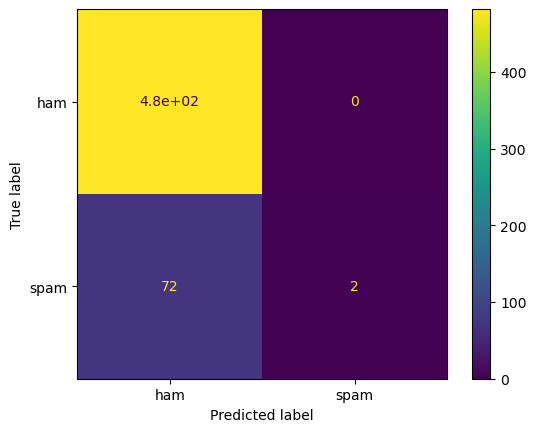

In [11]:
#Average fold results for visualization
TP = round(mean(res['TP']),0)
FP = round(mean(res['FP']),0)
TN = round(mean(res['TN']),0)
FN = round(mean(res['FN']),0)

#create array with results stored
data = np.array([[TN, FP], [FN, TP]])

#instantiate confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(data, display_labels = ['ham', 'spam'])

#plot
cm_display.plot()
plt.show()

In [31]:
#store list to for use in statistical comparison
f1_simple_case2 = res.loc[:,'F1'].tolist()
f1_simple_case2 = [i for i in f1_simple_case2 if not(math.isnan(i)) == True]

fpr_simple_case2 = res.loc[:,'FPR'].tolist()

print(f1_simple_case2)
%store f1_simple_case2
%store fpr_simple_case2

[0.04878048780487806, 0.02531645569620253, 0.10126582278481014, 0.1111111111111111, 0.025, 0.02857142857142857, 0.07792207792207792, 0.07058823529411765, 0.09230769230769231]
Stored 'f1_simple_case2' (list)
Stored 'fpr_simple_case2' (list)
